In [19]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import statsmodels.api as sm
import pytensor.tensor as pt
from pytensor import function
from pytensor.printing import Print
import seaborn as sns
import jax
import blackjax
# import numpyro

sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

In [20]:

az.style.use("arviz-darkgrid")

settings = {'figure.figsize':(14,4),
            'figure.dpi':144,
            'figure.facecolor':'w',
            'axes.spines.top':False,
            'axes.spines.bottom':False,
            'axes.spines.left':False,
            'axes.spines.right':False,
            'axes.grid':True,
            'grid.linestyle':'--',
            'grid.linewidth':0.5, 
            'figure.constrained_layout.use':True}
plt.rcParams.update(settings)

In [21]:
np.random.seed(42)

# Generate seasonal variables. 
def seasonal(t, amplitude, period):
    """Generate a sinusoidal curve."""
    return amplitude * np.sin((2*np.pi*t)/period) 

def generate_data(n, sigma_n = 0.3):
    """Generate sample data. 
    Two seasonal components, one linear trend and gaussian noise.
    """
    # Define "time" variable.
    t = np.arange(n)
    data_df = pd.DataFrame({'t' : t})
    # Add components:
    data_df['epsilon'] = np.random.normal(loc=0, scale=sigma_n, size=n)
    data_df['s1'] = data_df['t'].apply(lambda t: seasonal(t, amplitude=2, period=40)) 
    data_df['s2'] = data_df['t'].apply(lambda t: seasonal(t, amplitude=1, period=13.3)) 
    data_df['tr1'] = 0.01 * data_df['t']
    return data_df.eval('y = s1 + s2 + tr1 + epsilon')

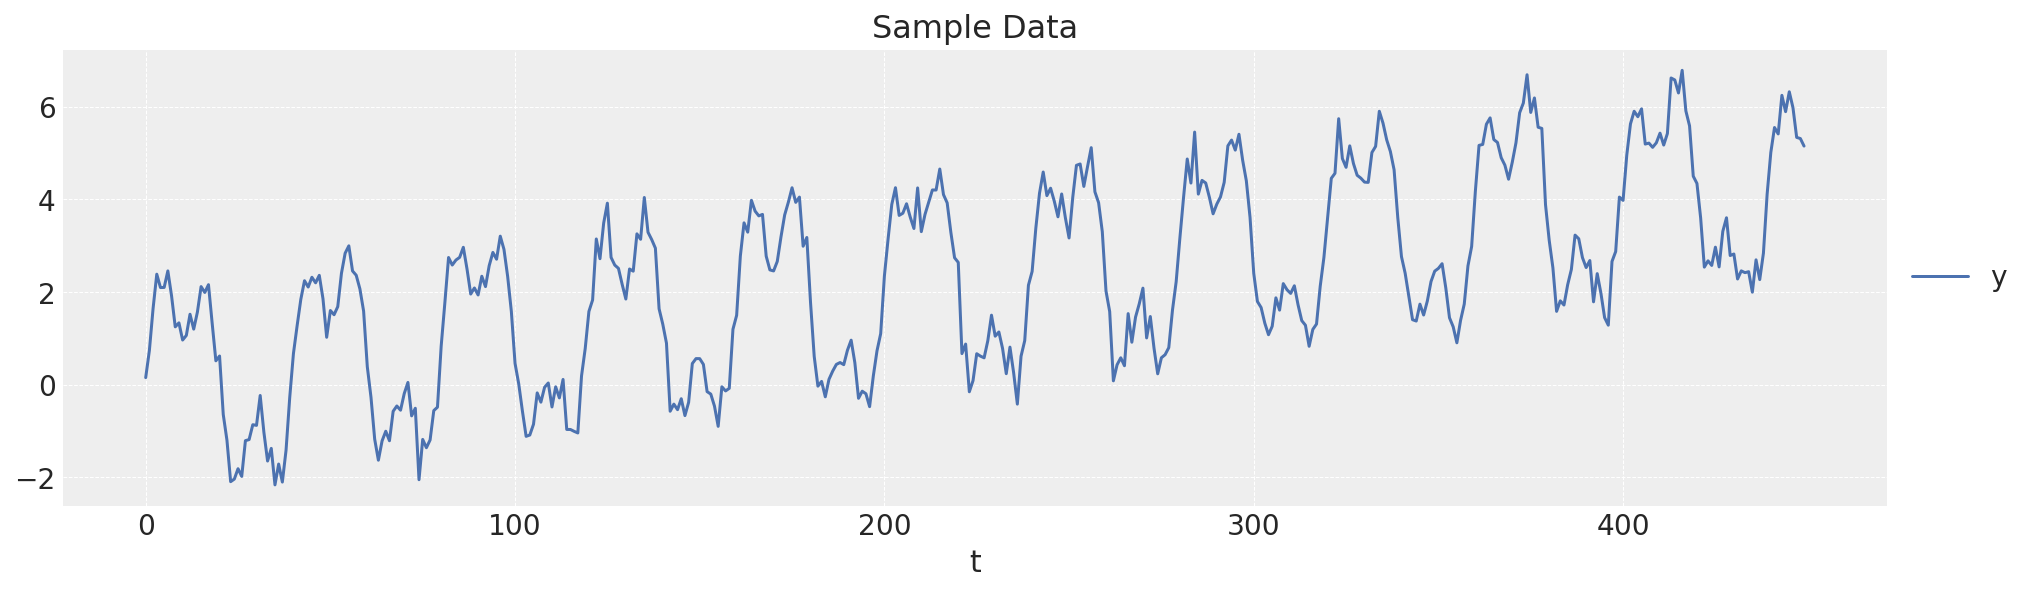

In [22]:
np.random.seed(42)

# Generate seasonal variables. 
def seasonal(t, amplitude, period):
    """Generate a sinusoidal curve."""
    return amplitude * np.sin((2*np.pi*t)/period) 

def generate_data(n, sigma_n = 0.3):
    """Generate sample data. 
    Two seasonal components, one linear trend and gaussian noise.
    """
    # Define "time" variable.
    t = np.arange(n)
    data_df = pd.DataFrame({'t' : t})
    # Add components:
    data_df['epsilon'] = np.random.normal(loc=0, scale=sigma_n, size=n)
    data_df['s1'] = data_df['t'].apply(lambda t: seasonal(t, amplitude=2, period=40)) 
    data_df['s2'] = data_df['t'].apply(lambda t: seasonal(t, amplitude=1, period=13.3)) 
    data_df['tr1'] = 0.01 * data_df['t']
    return data_df.eval('y = s1 + s2 + tr1 + epsilon')


# Number of samples.
n = 450
# Generate data.
data_df = generate_data(n=n)
# Plot. 
fig, ax = plt.subplots()
sns.lineplot(x='t', y='y', data=data_df, color=sns_c[0], label='y', ax=ax) 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Sample Data', xlabel='t', ylabel='');

### Train Test Split

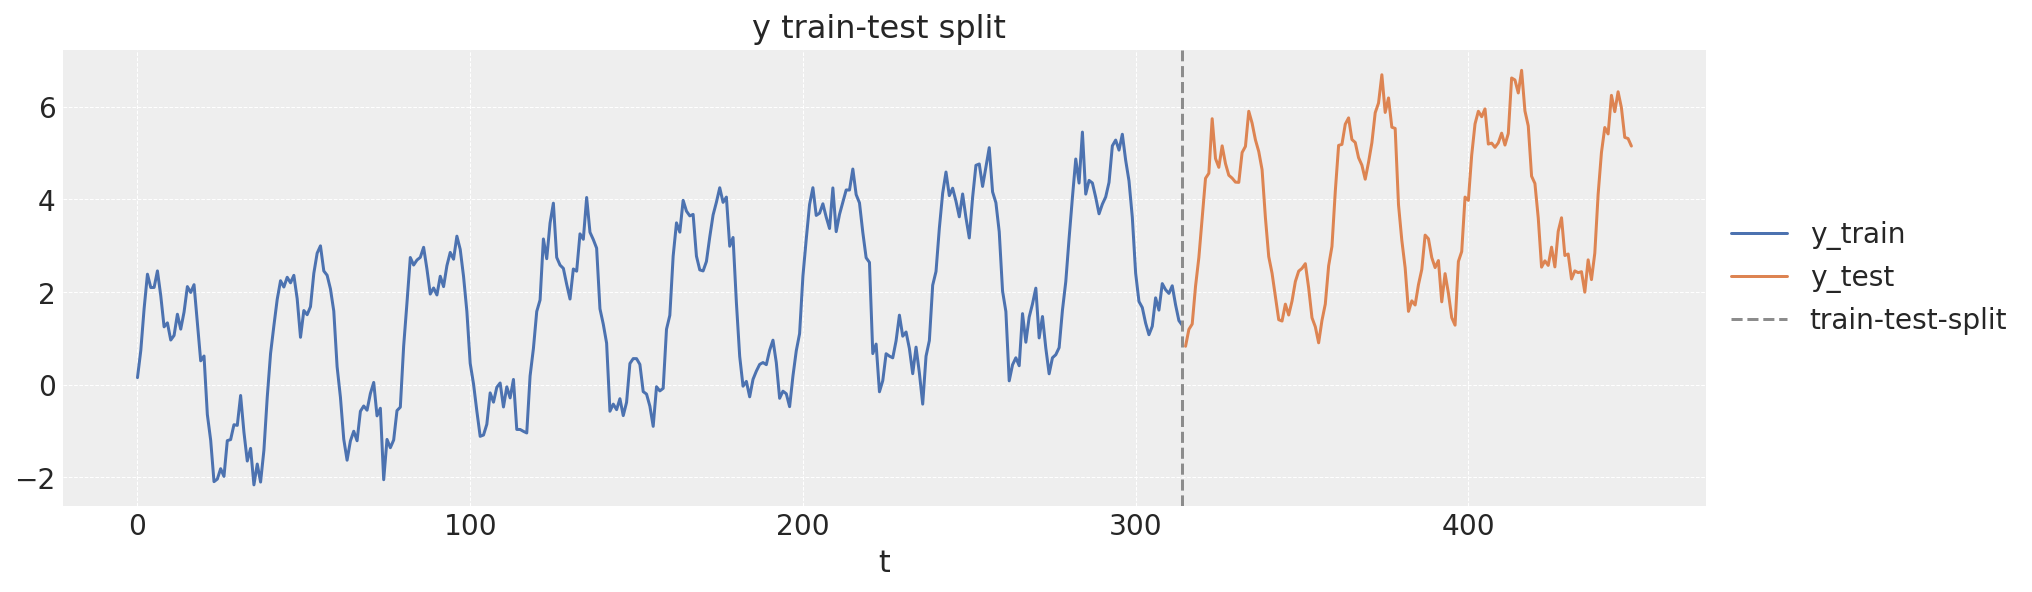

In [23]:
x = data_df['t'].values.reshape(n, 1)
y = data_df['y'].values.reshape(n, 1)

prop_train = 0.7
n_train = round(prop_train * n)

x_train = x[:n_train]
y_train = y[:n_train]

x_test = x[n_train:]
y_test = y[n_train:]

# Plot.
fig, ax = plt.subplots()
sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), color=sns_c[0], label='y_train', ax=ax)
sns.lineplot(x=x_test.flatten(), y=y_test.flatten(), color=sns_c[1], label='y_test', ax=ax)
ax.axvline(x=x_train.flatten()[-1], color=sns_c[7], linestyle='--', label='train-test-split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='y train-test split ', xlabel='t', ylabel='');

### Model

In [24]:
with pm.Model() as model:

    # First seasonal component.
    ls_1 = pm.Gamma(name='ls_1', alpha=2.0, beta=1.0)
    period_1 = pm.Gamma(name='period_1', alpha=80, beta=2)
    gp_1 = pm.gp.Marginal(cov_func=pm.gp.cov.Periodic(input_dim=1, period=period_1, ls=ls_1))
    # Second seasonal component.
    ls_2 = pm.Gamma(name='ls_2', alpha=2.0, beta=1.0)
    period_2 = pm.Gamma(name='period_2', alpha=30, beta=2)
    gp_2 = pm.gp.Marginal(cov_func=pm.gp.cov.Periodic(input_dim=1, period=period_2, ls=ls_2))
    # Linear trend.
    c_3 = pm.Normal(name='c_3', mu=1, sigma=2)
    gp_3 = pm.gp.Marginal(cov_func=pm.gp.cov.Linear(input_dim=1, c=c_3))
    # Define gaussian process.
    gp = gp_1 + gp_2 + gp_3
    # Noise.
    sigma = pm.HalfNormal(name='sigma', sigma=10)
    # Likelihood.
    y_pred = gp.marginal_likelihood('y_pred', X=x_train, y=y_train.flatten(), sigma=sigma)
    # Sample.
    #trace = pm.sample(init='jitter+adapt_diag_grad', draws=500, cores=4, chains=2)
    #trace =  pm.sample(nuts_sampler="numpyro", progressbar=False)
    #trace = pm.sample(nuts_sampler="blackjax")
    trace = pm.sample(nuts_sampler="nutpie")

    

/home/jpp/miniconda3/envs/pymc_env/lib/python3.12/site-packages/pytensor/link/numba/dispatch/basic.py:377: UserWarning: Numba will use object mode to run AdvancedSetSubtensor's perform method
  warnings.warn(
/home/jpp/miniconda3/envs/pymc_env/lib/python3.12/site-packages/pytensor/link/numba/dispatch/basic.py:377: UserWarning: Numba will use object mode to run AdvancedSetSubtensor's perform method
  warnings.warn(
/home/jpp/miniconda3/envs/pymc_env/lib/python3.12/site-packages/pytensor/graph/rewriting/basic.py:121: UserWarning: A Supervisor feature is missing from FunctionGraph(AdvancedSetSubtensor(Alloc(0.0, *2 -> Shape_i{0}(*0-<Vector(float64, shape=(?,))>), *2), *0-<Vector(float64, shape=(?,))>, *1 -> ARange{dtype='int64'}(0, *2, 1), *1)).
  return self.apply(fgraph, *args, **kwargs)
/home/jpp/miniconda3/envs/pymc_env/lib/python3.12/site-packages/pytensor/link/numba/dispatch/basic.py:377: UserWarning: Numba will use object mode to run AdvancedSetSubtensor's perform method
  warnings

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Failed in nopython mode pipeline (step: nopython frontend)
Invalid use of type(CPUDispatcher(<function careduce_axis at 0x7fb8507d5a80>)) with parameters (readonly array(float64, 2d, C))
Known signatures:
 * (Array(float64, 2, 'A', False, aligned=True),) -> array(float64, 1d, A)
During: resolving callee type: type(CPUDispatcher(<function careduce_axis at 0x7fb8507d5a80>))
During: typing of call at /tmp/tmpftmpdnxp (141)


File "../../../../../tmp/tmpftmpdnxp", line 141:
def numba_funcified_fgraph(_unconstrained_point):
    <source elided>
    # Sum{axis=1}(Sqr.0)
    tensor_variable_87 = careduce_axis_1(tensor_variable_85)
    ^

During: resolving callee type: type(CPUDispatcher(<function numba_funcified_fgraph at 0x7fb988516e80>))
During: typing of call at /home/jpp/miniconda3/envs/pymc_env/lib/python3.12/site-packages/nutpie/compile_pymc.py (554)

During: resolving callee type: type(CPUDispatcher(<function numba_funcified_fgraph at 0x7fb988516e80>))
During: typing of call at /home/jpp/miniconda3/envs/pymc_env/lib/python3.12/site-packages/nutpie/compile_pymc.py (554)


File "../../../miniconda3/envs/pymc_env/lib/python3.12/site-packages/nutpie/compile_pymc.py", line 554:
        def extract_shared(x, user_data_):
            return inner(x)
            ^


In [ ]:
# Plot parameters posterior distribution.
az.plot_trace(trace);

In [ ]:
# Get model summary.
pm.summary(trace)

In [ ]:
trace

In [ ]:
with model:
    
    x_train_conditional2 = gp.conditional('x_train_conditional2', x_train)
    y_train_pred_samples = pm.sample_posterior_predictive(trace, sample_dims=[x_train_conditional2], samples=100)

    x_test_conditional2 = gp.conditional('x_test_conditional2', x_test)
    y_test_pred_samples = pm.sample_posterior_predictive(trace, sample_dims=[x_test_conditional2], samples=100)

In [ ]:
# Train
y_train_pred_samples_mean = y_train_pred_samples['x_train_conditional'].mean(axis=0)
y_train_pred_samples_std = y_train_pred_samples['x_train_conditional'].std(axis=0)
y_train_pred_samples_mean_plus = y_train_pred_samples_mean + 2*y_train_pred_samples_std
y_train_pred_samples_mean_minus = y_train_pred_samples_mean - 2*y_train_pred_samples_std
# Test
y_test_pred_samples_mean = y_test_pred_samples['x_test_conditional'].mean(axis=0)
y_test_pred_samples_std = y_test_pred_samples['x_test_conditional'].std(axis=0)
y_test_pred_samples_mean_plus = y_test_pred_samples_mean + 2*y_test_pred_samples_std
y_test_pred_samples_mean_minus = y_test_pred_samples_mean - 2*y_test_pred_samples_std

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), color=sns_c[0], label='y_train', ax=ax)
sns.lineplot(x=x_test.flatten(), y=y_test.flatten(), color=sns_c[1], label='y_test', ax=ax)
ax.fill_between(
    x=x_train.flatten(), 
    y1=y_train_pred_samples_mean_minus, 
    y2=y_train_pred_samples_mean_plus, 
    color=sns_c[2], 
    alpha=0.2, 
    label='credible_interval (train)'
)
sns.lineplot(x=x_train.flatten(), y=y_train_pred_samples_mean, color=sns_c[2], label='y_pred_train', ax=ax)
ax.fill_between(
    x=x_test.flatten(), 
    y1=y_test_pred_samples_mean_minus, 
    y2=y_test_pred_samples_mean_plus, 
    color=sns_c[3], 
    alpha=0.2, 
    label='credible_interval (test)'
)
sns.lineplot(x=x_test.flatten(), y=y_test_pred_samples_mean, color=sns_c[3], label='y_pred_test', ax=ax)
ax.axvline(x=x_train.flatten()[-1], color=sns_c[7], linestyle='--', label='train-test-split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Model Predictions', xlabel='t', ylabel='');